In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0c21909f-47d6-3228-b7b6-43a979e79e18)


In [2]:
!pip install ultralytics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.3/496.3 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 14.6 MB/s eta 0:00:00


In [3]:
!mkdir Dataset

In [4]:
!unzip '/content/drive/MyDrive/new_article/Bird-species/cub_200_2011_xml.zip' -d '/content/Dataset/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/valid_labels/Bobolink_0074_9311.xml  
  inflating: /content/Dataset/valid_labels/Bobolink_0076_11093.xml  
  inflating: /content/Dataset/valid_labels/Bobolink_0079_10736.xml  
  inflating: /content/Dataset/valid_labels/Bobolink_0081_9439.xml  
  inflating: /content/Dataset/valid_labels/Bobolink_0097_10861.xml  
  inflating: /content/Dataset/valid_labels/Bobolink_0106_9126.xml  
  inflating: /content/Dataset/valid_labels/Bobolink_0109_9869.xml  
  inflating: /content/Dataset/valid_labels/Bobolink_0110_9496.xml  
  inflating: /content/Dataset/valid_labels/Bobolink_0112_11073.xml  
  inflating: /content/Dataset/valid_labels/Bobolink_0114_10627.xml  
  inflating: /content/Dataset/valid_labels/Bobolink_0115_9265.xml  
  inflating: /content/Dataset/valid_labels/Bobolink_0120_10859.xml  
  inflating: /content/Dataset/valid_labels/Bobolink_0126_11458.xml  
  inflating: /content/Dataset/valid_labels/Bobolink_0128_9

In [5]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

%matplotlib inline



In [6]:
# Function to get the data from XML Annotation
def extract_xml_file(xml_file):
    xml_root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    img_info_dict = {}
    img_info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in xml_root:
        # Get the file name 
        if elem.tag == "filename":
            img_info_dict['filename'] = elem.text
            
        # Get size of the image
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            img_info_dict['image_size'] = tuple(image_size)
        
        # Get bounding box of the image
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            img_info_dict['bboxes'].append(bbox)
    
    return img_info_dict

In [7]:
print(extract_xml_file('/content/Dataset/train_labels/Acadian_Flycatcher_0003_29094.xml'))


{'bboxes': [{'class': 'Acadian Flycatcher', 'xmin': 216, 'ymin': 68, 'xmax': 403, 'ymax': 344}], 'filename': 'Acadian_Flycatcher_0003_29094', 'image_size': (500, 400, 3)}


In [8]:
class_names = []
class_name_to_id_mapping = {}

# get class names 
def get_class_names(info_dict):
  for b in info_dict['bboxes']:
      class_names.append(b['class'])
  
def mapping_to_class_name_to_id(class_names):
  unique_class_names = np.unique(class_names)
  for i, unique_label in enumerate(unique_class_names):
    class_name_to_id_mapping[unique_label] = i


In [9]:
# Get the all train and validation xml annotations file path
train_annotations_labels = [os.path.join('/content/Dataset/train_labels/', x) for x in os.listdir('/content/Dataset/train_labels/') if x[-3:] == "xml"]
train_annotations_labels.sort()
# # test
test_annotations_labels = [os.path.join('/content/Dataset/valid_labels/', x) for x in os.listdir('/content/Dataset/valid_labels/') if x[-3:] == "xml"] 
test_annotations_labels.sort()


# extract xml file and append label into class_names list container
for i,ann in enumerate(tqdm(train_annotations_labels)):
    info_dict = extract_xml_file(ann)
    get_class_names(info_dict)

# If all label store on list container than mapping them unique number 
mapping_to_class_name_to_id(class_names)

100%|██████████| 5993/5993 [00:00<00:00, 17283.83it/s]


In [10]:
len(train_annotations_labels),len(class_name_to_id_mapping),len(test_annotations_labels)

(5993, 200, 5794)

In [11]:
class_name_to_id_mapping

{'Acadian Flycatcher': 0,
 'American Crow': 1,
 'American Goldfinch': 2,
 'American Pipit': 3,
 'American Redstart': 4,
 'American Three Toed Woodpecker': 5,
 'Anna Hummingbird': 6,
 'Artic Tern': 7,
 'Baird Sparrow': 8,
 'Baltimore Oriole': 9,
 'Bank Swallow': 10,
 'Barn Swallow': 11,
 'Bay Breasted Warbler': 12,
 'Belted Kingfisher': 13,
 'Bewick Wren': 14,
 'Black And White Warbler': 15,
 'Black Billed Cuckoo': 16,
 'Black Capped Vireo': 17,
 'Black Footed Albatross': 18,
 'Black Tern': 19,
 'Black Throated Blue Warbler': 20,
 'Black Throated Sparrow': 21,
 'Blue Grosbeak': 22,
 'Blue Headed Vireo': 23,
 'Blue Jay': 24,
 'Blue Winged Warbler': 25,
 'Boat Tailed Grackle': 26,
 'Bobolink': 27,
 'Bohemian Waxwing': 28,
 'Brandt Cormorant': 29,
 'Brewer Blackbird': 30,
 'Brewer Sparrow': 31,
 'Bronzed Cowbird': 32,
 'Brown Creeper': 33,
 'Brown Pelican': 34,
 'Brown Thrasher': 35,
 'Cactus Wren': 36,
 'California Gull': 37,
 'Canada Warbler': 38,
 'Cape Glossy Starling': 39,
 'Cape May 

In [12]:
#Convert the info dict to the required yolo txl file format and write it to disk
def convert_to_yolov8(info_dict,path):
    print_buffer = []
    
    # For each bounding box
    for bbox in info_dict["bboxes"]:
     

        try:
            # get class id for each label
            class_id = class_name_to_id_mapping[bbox["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v8
        b_center_x = (bbox["xmin"] + bbox["xmax"]) / 2 
        b_center_y = (bbox["ymin"] + bbox["ymax"]) / 2
        b_width    = (bbox["xmax"] - bbox["xmin"])
        b_height   = (bbox["ymax"] - bbox["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bounding box details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join(path, info_dict["filename"].replace("jpg", ""))
    save_file_name += '.txt'
    print(save_file_name)
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [13]:

# Convert and save the train annotations
for i,ann in enumerate(tqdm(train_annotations_labels)):
    info_dict = extract_xml_file(ann)
    convert_to_yolov8(info_dict,'/content/Dataset/train_images/')

train_annotations_labels = [os.path.join('/content/Dataset/train_images/', x) for x in os.listdir('/content/Dataset/train_images/') if x[-3:] == "txt"]

# Convert and save the test annotations
for i,ann in enumerate(tqdm(test_annotations_labels)):
    info_dict = extract_xml_file(ann)
    convert_to_yolov8(info_dict,'/content/Dataset/valid_images/')

test_annotations_labels = [os.path.join('/content/Dataset/valid_images/', x) for x in os.listdir('/content/Dataset/valid_images/') if x[-3:] == "txt"]

  6%|▌         | 338/5993 [00:00<00:03, 1692.42it/s]

/content/Dataset/train_images/Acadian_Flycatcher_0003_29094.txt
/content/Dataset/train_images/Acadian_Flycatcher_0004_795623.txt
/content/Dataset/train_images/Acadian_Flycatcher_0006_795595.txt
/content/Dataset/train_images/Acadian_Flycatcher_0007_795600.txt
/content/Dataset/train_images/Acadian_Flycatcher_0008_795599.txt
/content/Dataset/train_images/Acadian_Flycatcher_0009_29155.txt
/content/Dataset/train_images/Acadian_Flycatcher_0010_29199.txt
/content/Dataset/train_images/Acadian_Flycatcher_0014_795607.txt
/content/Dataset/train_images/Acadian_Flycatcher_0016_29217.txt
/content/Dataset/train_images/Acadian_Flycatcher_0017_795598.txt
/content/Dataset/train_images/Acadian_Flycatcher_0019_795592.txt
/content/Dataset/train_images/Acadian_Flycatcher_0020_29069.txt
/content/Dataset/train_images/Acadian_Flycatcher_0028_795611.txt
/content/Dataset/train_images/Acadian_Flycatcher_0032_795622.txt
/content/Dataset/train_images/Acadian_Flycatcher_0033_29195.txt
/content/Dataset/train_images/A

 11%|█▏        | 679/5993 [00:00<00:03, 1676.35it/s]

/content/Dataset/train_images/Barn_Swallow_0064_132688.txt
/content/Dataset/train_images/Barn_Swallow_0065_131555.txt
/content/Dataset/train_images/Barn_Swallow_0066_130214.txt
/content/Dataset/train_images/Barn_Swallow_0069_130368.txt
/content/Dataset/train_images/Barn_Swallow_0070_130127.txt
/content/Dataset/train_images/Barn_Swallow_0073_131389.txt
/content/Dataset/train_images/Barn_Swallow_0075_130014.txt
/content/Dataset/train_images/Barn_Swallow_0076_130757.txt
/content/Dataset/train_images/Barn_Swallow_0077_130707.txt
/content/Dataset/train_images/Barn_Swallow_0078_130385.txt
/content/Dataset/train_images/Barn_Swallow_0084_130800.txt
/content/Dataset/train_images/Barn_Swallow_0094_132154.txt
/content/Dataset/train_images/Bay_Breasted_Warbler_0005_159739.txt
/content/Dataset/train_images/Bay_Breasted_Warbler_0011_159736.txt
/content/Dataset/train_images/Bay_Breasted_Warbler_0012_797171.txt
/content/Dataset/train_images/Bay_Breasted_Warbler_0020_159737.txt
/content/Dataset/train_i

 14%|█▍        | 847/5993 [00:00<00:03, 1541.72it/s]

/content/Dataset/train_images/Blue_Grosbeak_0093_37107.txt
/content/Dataset/train_images/Blue_Grosbeak_0094_36995.txt
/content/Dataset/train_images/Blue_Grosbeak_0099_36828.txt
/content/Dataset/train_images/Blue_Grosbeak_0101_36719.txt
/content/Dataset/train_images/Blue_Grosbeak_0103_36673.txt
/content/Dataset/train_images/Blue_Grosbeak_0107_36696.txt
/content/Dataset/train_images/Blue_Grosbeak_0111_36841.txt
/content/Dataset/train_images/Blue_Headed_Vireo_0009_155953.txt
/content/Dataset/train_images/Blue_Headed_Vireo_0010_156344.txt
/content/Dataset/train_images/Blue_Headed_Vireo_0011_156276.txt
/content/Dataset/train_images/Blue_Headed_Vireo_0019_156311.txt
/content/Dataset/train_images/Blue_Headed_Vireo_0020_155994.txt
/content/Dataset/train_images/Blue_Headed_Vireo_0023_156112.txt
/content/Dataset/train_images/Blue_Headed_Vireo_0025_156439.txt
/content/Dataset/train_images/Blue_Headed_Vireo_0026_156245.txt
/content/Dataset/train_images/Blue_Headed_Vireo_0031_156056.txt
/content/Da

 20%|█▉        | 1183/5993 [00:00<00:02, 1617.51it/s]

/content/Dataset/train_images/Brown_Creeper_0047_24984.txt
/content/Dataset/train_images/Brown_Creeper_0048_24976.txt
/content/Dataset/train_images/Brown_Creeper_0049_24911.txt
/content/Dataset/train_images/Brown_Creeper_0053_24451.txt
/content/Dataset/train_images/Brown_Creeper_0058_24933.txt
/content/Dataset/train_images/Brown_Creeper_0059_25010.txt
/content/Dataset/train_images/Brown_Creeper_0061_24601.txt
/content/Dataset/train_images/Brown_Creeper_0063_24724.txt
/content/Dataset/train_images/Brown_Creeper_0064_24840.txt
/content/Dataset/train_images/Brown_Creeper_0072_24977.txt
/content/Dataset/train_images/Brown_Creeper_0074_24789.txt
/content/Dataset/train_images/Brown_Creeper_0083_24967.txt
/content/Dataset/train_images/Brown_Creeper_0100_24502.txt
/content/Dataset/train_images/Brown_Creeper_0103_24632.txt
/content/Dataset/train_images/Brown_Creeper_0106_24617.txt
/content/Dataset/train_images/Brown_Creeper_0110_24866.txt
/content/Dataset/train_images/Brown_Creeper_0113_24560.t

 25%|██▌       | 1518/5993 [00:00<00:02, 1636.91it/s]

/content/Dataset/train_images/Cerulean_Warbler_0012_163417.txt
/content/Dataset/train_images/Cerulean_Warbler_0014_797226.txt
/content/Dataset/train_images/Cerulean_Warbler_0018_797183.txt
/content/Dataset/train_images/Cerulean_Warbler_0020_163353.txt
/content/Dataset/train_images/Cerulean_Warbler_0023_797191.txt
/content/Dataset/train_images/Cerulean_Warbler_0033_797176.txt
/content/Dataset/train_images/Cerulean_Warbler_0035_163269.txt
/content/Dataset/train_images/Cerulean_Warbler_0038_797230.txt
/content/Dataset/train_images/Cerulean_Warbler_0039_163420.txt
/content/Dataset/train_images/Cerulean_Warbler_0045_797217.txt
/content/Dataset/train_images/Cerulean_Warbler_0047_797211.txt
/content/Dataset/train_images/Cerulean_Warbler_0056_163339.txt
/content/Dataset/train_images/Cerulean_Warbler_0060_797209.txt
/content/Dataset/train_images/Cerulean_Warbler_0063_797204.txt
/content/Dataset/train_images/Cerulean_Warbler_0071_163201.txt
/content/Dataset/train_images/Cerulean_Warbler_0072_163

 34%|███▍      | 2035/5993 [00:01<00:02, 1672.46it/s]

/content/Dataset/train_images/Dark_Eyed_Junco_0090_69051.txt
/content/Dataset/train_images/Dark_Eyed_Junco_0091_67304.txt
/content/Dataset/train_images/Dark_Eyed_Junco_0094_68735.txt
/content/Dataset/train_images/Dark_Eyed_Junco_0096_68514.txt
/content/Dataset/train_images/Dark_Eyed_Junco_0099_67868.txt
/content/Dataset/train_images/Dark_Eyed_Junco_0103_67700.txt
/content/Dataset/train_images/Dark_Eyed_Junco_0109_66326.txt
/content/Dataset/train_images/Dark_Eyed_Junco_0113_68470.txt
/content/Dataset/train_images/Dark_Eyed_Junco_0115_68840.txt
/content/Dataset/train_images/Dark_Eyed_Junco_0130_67867.txt
/content/Dataset/train_images/Dark_Eyed_Junco_0132_66476.txt
/content/Dataset/train_images/Downy_Woodpecker_0003_183933.txt
/content/Dataset/train_images/Downy_Woodpecker_0005_184098.txt
/content/Dataset/train_images/Downy_Woodpecker_0007_184051.txt
/content/Dataset/train_images/Downy_Woodpecker_0011_183934.txt
/content/Dataset/train_images/Downy_Woodpecker_0014_183975.txt
/content/Datas

 37%|███▋      | 2203/5993 [00:01<00:02, 1628.66it/s]

/content/Dataset/train_images/Frigatebird_0068_42795.txt
/content/Dataset/train_images/Frigatebird_0070_43516.txt
/content/Dataset/train_images/Frigatebird_0080_43064.txt
/content/Dataset/train_images/Frigatebird_0082_42989.txt
/content/Dataset/train_images/Frigatebird_0084_43006.txt
/content/Dataset/train_images/Frigatebird_0090_43511.txt
/content/Dataset/train_images/Frigatebird_0095_42785.txt
/content/Dataset/train_images/Frigatebird_0107_42773.txt
/content/Dataset/train_images/Frigatebird_0112_43394.txt
/content/Dataset/train_images/Frigatebird_0114_42807.txt
/content/Dataset/train_images/Frigatebird_0115_42973.txt
/content/Dataset/train_images/Frigatebird_0116_43410.txt
/content/Dataset/train_images/Frigatebird_0119_43042.txt
/content/Dataset/train_images/Gadwall_0001_31235.txt
/content/Dataset/train_images/Gadwall_0005_30924.txt
/content/Dataset/train_images/Gadwall_0012_30920.txt
/content/Dataset/train_images/Gadwall_0017_30979.txt
/content/Dataset/train_images/Gadwall_0024_3094

 42%|████▏     | 2535/5993 [00:01<00:02, 1599.20it/s]

/content/Dataset/train_images/Great_Grey_Shrike_0064_106778.txt
/content/Dataset/train_images/Great_Grey_Shrike_0070_106547.txt
/content/Dataset/train_images/Great_Grey_Shrike_0076_797050.txt
/content/Dataset/train_images/Great_Grey_Shrike_0079_797018.txt
/content/Dataset/train_images/Great_Grey_Shrike_0083_797051.txt
/content/Dataset/train_images/Great_Grey_Shrike_0089_797036.txt
/content/Dataset/train_images/Great_Grey_Shrike_0092_797048.txt
/content/Dataset/train_images/Green_Jay_0003_65767.txt
/content/Dataset/train_images/Green_Jay_0006_65788.txt
/content/Dataset/train_images/Green_Jay_0014_65825.txt
/content/Dataset/train_images/Green_Jay_0015_65796.txt
/content/Dataset/train_images/Green_Jay_0016_65864.txt
/content/Dataset/train_images/Green_Jay_0020_66168.txt
/content/Dataset/train_images/Green_Jay_0023_65898.txt
/content/Dataset/train_images/Green_Jay_0032_65851.txt
/content/Dataset/train_images/Green_Jay_0036_65660.txt
/content/Dataset/train_images/Green_Jay_0039_66118.txt
/c

 51%|█████     | 3039/5993 [00:01<00:01, 1647.02it/s]

/content/Dataset/train_images/Hooded_Warbler_0013_164627.txt
/content/Dataset/train_images/Hooded_Warbler_0014_164672.txt
/content/Dataset/train_images/Hooded_Warbler_0016_164837.txt
/content/Dataset/train_images/Hooded_Warbler_0021_165057.txt
/content/Dataset/train_images/Hooded_Warbler_0039_164928.txt
/content/Dataset/train_images/Hooded_Warbler_0040_165173.txt
/content/Dataset/train_images/Hooded_Warbler_0041_164807.txt
/content/Dataset/train_images/Hooded_Warbler_0043_164864.txt
/content/Dataset/train_images/Hooded_Warbler_0053_164631.txt
/content/Dataset/train_images/Hooded_Warbler_0057_164137.txt
/content/Dataset/train_images/Hooded_Warbler_0058_164674.txt
/content/Dataset/train_images/Hooded_Warbler_0062_165199.txt
/content/Dataset/train_images/Hooded_Warbler_0070_164930.txt
/content/Dataset/train_images/Hooded_Warbler_0078_165123.txt
/content/Dataset/train_images/Hooded_Warbler_0084_164944.txt
/content/Dataset/train_images/Hooded_Warbler_0085_164846.txt
/content/Dataset/train_i

 53%|█████▎    | 3204/5993 [00:01<00:01, 1535.91it/s]

/content/Dataset/train_images/Least_Auklet_0008_795071.txt
/content/Dataset/train_images/Least_Auklet_0010_795092.txt
/content/Dataset/train_images/Least_Auklet_0011_795109.txt
/content/Dataset/train_images/Least_Auklet_0012_795074.txt
/content/Dataset/train_images/Least_Auklet_0015_795065.txt
/content/Dataset/train_images/Least_Auklet_0016_1903.txt
/content/Dataset/train_images/Least_Auklet_0017_795084.txt
/content/Dataset/train_images/Least_Auklet_0018_795077.txt
/content/Dataset/train_images/Least_Auklet_0020_795080.txt
/content/Dataset/train_images/Least_Auklet_0021_795127.txt
/content/Dataset/train_images/Least_Auklet_0024_795120.txt
/content/Dataset/train_images/Least_Auklet_0026_795066.txt
/content/Dataset/train_images/Least_Auklet_0027_795091.txt
/content/Dataset/train_images/Least_Auklet_0029_795122.txt
/content/Dataset/train_images/Least_Auklet_0030_795116.txt
/content/Dataset/train_images/Least_Auklet_0034_795096.txt
/content/Dataset/train_images/Least_Auklet_0035_1888.txt
/

 59%|█████▉    | 3532/5993 [00:02<00:01, 1586.06it/s]

/content/Dataset/train_images/Mangrove_Cuckoo_0036_794606.txt
/content/Dataset/train_images/Mangrove_Cuckoo_0038_794600.txt
/content/Dataset/train_images/Mangrove_Cuckoo_0039_26348.txt
/content/Dataset/train_images/Mangrove_Cuckoo_0041_26370.txt
/content/Dataset/train_images/Mangrove_Cuckoo_0042_794628.txt
/content/Dataset/train_images/Mangrove_Cuckoo_0044_26393.txt
/content/Dataset/train_images/Mangrove_Cuckoo_0045_794612.txt
/content/Dataset/train_images/Mangrove_Cuckoo_0046_794616.txt
/content/Dataset/train_images/Mangrove_Cuckoo_0048_26351.txt
/content/Dataset/train_images/Mangrove_Cuckoo_0050_794594.txt
/content/Dataset/train_images/Mangrove_Cuckoo_0051_794627.txt
/content/Dataset/train_images/Mangrove_Cuckoo_0052_794608.txt
/content/Dataset/train_images/Marsh_Wren_0005_188235.txt
/content/Dataset/train_images/Marsh_Wren_0006_188126.txt
/content/Dataset/train_images/Marsh_Wren_0008_188533.txt
/content/Dataset/train_images/Marsh_Wren_0012_188275.txt
/content/Dataset/train_images/Ma

 64%|██████▍   | 3861/5993 [00:02<00:01, 1583.71it/s]

/content/Dataset/train_images/Olive_Sided_Flycatcher_0040_30620.txt
/content/Dataset/train_images/Olive_Sided_Flycatcher_0049_796889.txt
/content/Dataset/train_images/Olive_Sided_Flycatcher_0052_30639.txt
/content/Dataset/train_images/Olive_Sided_Flycatcher_0054_30732.txt
/content/Dataset/train_images/Olive_Sided_Flycatcher_0059_30536.txt
/content/Dataset/train_images/Olive_Sided_Flycatcher_0061_30540.txt
/content/Dataset/train_images/Olive_Sided_Flycatcher_0064_30485.txt
/content/Dataset/train_images/Olive_Sided_Flycatcher_0067_30749.txt
/content/Dataset/train_images/Olive_Sided_Flycatcher_0070_30490.txt
/content/Dataset/train_images/Olive_Sided_Flycatcher_0071_30647.txt
/content/Dataset/train_images/Olive_Sided_Flycatcher_0076_30555.txt
/content/Dataset/train_images/Olive_Sided_Flycatcher_0078_30752.txt
/content/Dataset/train_images/Olive_Sided_Flycatcher_0080_30515.txt
/content/Dataset/train_images/Olive_Sided_Flycatcher_0086_30553.txt
/content/Dataset/train_images/Orange_Crowned_Wa

 70%|██████▉   | 4182/5993 [00:02<00:01, 1503.95it/s]

/content/Dataset/train_images/Pied_Billed_Grebe_0100_35310.txt
/content/Dataset/train_images/Pied_Billed_Grebe_0113_35703.txt
/content/Dataset/train_images/Pied_Billed_Grebe_0114_35493.txt
/content/Dataset/train_images/Pied_Billed_Grebe_0115_35362.txt
/content/Dataset/train_images/Pied_Billed_Grebe_0119_35377.txt
/content/Dataset/train_images/Pied_Billed_Grebe_0120_35764.txt
/content/Dataset/train_images/Pied_Billed_Grebe_0122_35970.txt
/content/Dataset/train_images/Pied_Billed_Grebe_0123_35469.txt
/content/Dataset/train_images/Pied_Billed_Grebe_0125_35322.txt
/content/Dataset/train_images/Pied_Kingfisher_0007_72438.txt
/content/Dataset/train_images/Pied_Kingfisher_0011_72143.txt
/content/Dataset/train_images/Pied_Kingfisher_0014_72119.txt
/content/Dataset/train_images/Pied_Kingfisher_0016_72280.txt
/content/Dataset/train_images/Pied_Kingfisher_0017_72316.txt
/content/Dataset/train_images/Pied_Kingfisher_0019_72659.txt
/content/Dataset/train_images/Pied_Kingfisher_0022_72247.txt
/conte

 75%|███████▌  | 4499/5993 [00:02<00:00, 1539.74it/s]

/content/Dataset/train_images/Red_Breasted_Merganser_0017_79224.txt
/content/Dataset/train_images/Red_Breasted_Merganser_0021_79168.txt
/content/Dataset/train_images/Red_Breasted_Merganser_0022_79274.txt
/content/Dataset/train_images/Red_Breasted_Merganser_0023_79477.txt
/content/Dataset/train_images/Red_Breasted_Merganser_0032_79280.txt
/content/Dataset/train_images/Red_Breasted_Merganser_0033_79353.txt
/content/Dataset/train_images/Red_Breasted_Merganser_0040_79207.txt
/content/Dataset/train_images/Red_Breasted_Merganser_0044_79321.txt
/content/Dataset/train_images/Red_Breasted_Merganser_0046_79330.txt
/content/Dataset/train_images/Red_Breasted_Merganser_0047_79486.txt
/content/Dataset/train_images/Red_Breasted_Merganser_0048_79323.txt
/content/Dataset/train_images/Red_Breasted_Merganser_0049_79432.txt
/content/Dataset/train_images/Red_Breasted_Merganser_0054_79542.txt
/content/Dataset/train_images/Red_Breasted_Merganser_0055_79397.txt
/content/Dataset/train_images/Red_Breasted_Merga

 81%|████████  | 4839/5993 [00:03<00:00, 1600.12it/s]

/content/Dataset/train_images/Rose_Breasted_Grosbeak_0095_39178.txt
/content/Dataset/train_images/Rose_Breasted_Grosbeak_0097_39514.txt
/content/Dataset/train_images/Rose_Breasted_Grosbeak_0104_39189.txt
/content/Dataset/train_images/Rose_Breasted_Grosbeak_0106_39714.txt
/content/Dataset/train_images/Rose_Breasted_Grosbeak_0114_39770.txt
/content/Dataset/train_images/Rose_Breasted_Grosbeak_0125_39597.txt
/content/Dataset/train_images/Rose_Breasted_Grosbeak_0135_39227.txt
/content/Dataset/train_images/Ruby_Throated_Hummingbird_0001_58162.txt
/content/Dataset/train_images/Ruby_Throated_Hummingbird_0003_58269.txt
/content/Dataset/train_images/Ruby_Throated_Hummingbird_0010_58285.txt
/content/Dataset/train_images/Ruby_Throated_Hummingbird_0024_57969.txt
/content/Dataset/train_images/Ruby_Throated_Hummingbird_0027_58191.txt
/content/Dataset/train_images/Ruby_Throated_Hummingbird_0030_57422.txt
/content/Dataset/train_images/Ruby_Throated_Hummingbird_0034_58148.txt
/content/Dataset/train_imag

 86%|████████▌ | 5167/5993 [00:03<00:00, 1615.74it/s]

/content/Dataset/train_images/Slaty_Backed_Gull_0045_796025.txt
/content/Dataset/train_images/Slaty_Backed_Gull_0046_796035.txt
/content/Dataset/train_images/Slaty_Backed_Gull_0049_53318.txt
/content/Dataset/train_images/Slaty_Backed_Gull_0051_796031.txt
/content/Dataset/train_images/Slaty_Backed_Gull_0053_796051.txt
/content/Dataset/train_images/Slaty_Backed_Gull_0056_796013.txt
/content/Dataset/train_images/Slaty_Backed_Gull_0058_796024.txt
/content/Dataset/train_images/Slaty_Backed_Gull_0060_796052.txt
/content/Dataset/train_images/Slaty_Backed_Gull_0068_53206.txt
/content/Dataset/train_images/Slaty_Backed_Gull_0071_796037.txt
/content/Dataset/train_images/Slaty_Backed_Gull_0072_53314.txt
/content/Dataset/train_images/Slaty_Backed_Gull_0076_796005.txt
/content/Dataset/train_images/Slaty_Backed_Gull_0077_796017.txt
/content/Dataset/train_images/Slaty_Backed_Gull_0081_53264.txt
/content/Dataset/train_images/Slaty_Backed_Gull_0084_786383.txt
/content/Dataset/train_images/Slaty_Backed_G

 92%|█████████▏| 5514/5993 [00:03<00:00, 1559.13it/s]

/content/Dataset/train_images/Vesper_Sparrow_0076_125737.txt
/content/Dataset/train_images/Vesper_Sparrow_0079_125579.txt
/content/Dataset/train_images/Vesper_Sparrow_0080_125606.txt
/content/Dataset/train_images/Vesper_Sparrow_0084_125532.txt
/content/Dataset/train_images/Vesper_Sparrow_0087_125712.txt
/content/Dataset/train_images/Vesper_Sparrow_0090_125690.txt
/content/Dataset/train_images/Vesper_Sparrow_0094_125602.txt
/content/Dataset/train_images/Warbling_Vireo_0002_158319.txt
/content/Dataset/train_images/Warbling_Vireo_0003_158484.txt
/content/Dataset/train_images/Warbling_Vireo_0004_158376.txt
/content/Dataset/train_images/Warbling_Vireo_0007_158717.txt
/content/Dataset/train_images/Warbling_Vireo_0014_158412.txt
/content/Dataset/train_images/Warbling_Vireo_0016_158681.txt
/content/Dataset/train_images/Warbling_Vireo_0017_158271.txt
/content/Dataset/train_images/Warbling_Vireo_0022_158144.txt
/content/Dataset/train_images/Warbling_Vireo_0027_158576.txt
/content/Dataset/train_i

 98%|█████████▊| 5853/5993 [00:03<00:00, 1610.61it/s]

/content/Dataset/train_images/White_Necked_Raven_0004_102714.txt
/content/Dataset/train_images/White_Necked_Raven_0007_102676.txt
/content/Dataset/train_images/White_Necked_Raven_0010_797350.txt
/content/Dataset/train_images/White_Necked_Raven_0014_102687.txt
/content/Dataset/train_images/White_Necked_Raven_0018_102746.txt
/content/Dataset/train_images/White_Necked_Raven_0020_102730.txt
/content/Dataset/train_images/White_Necked_Raven_0021_797341.txt
/content/Dataset/train_images/White_Necked_Raven_0023_797371.txt
/content/Dataset/train_images/White_Necked_Raven_0025_797346.txt
/content/Dataset/train_images/White_Necked_Raven_0026_797357.txt
/content/Dataset/train_images/White_Necked_Raven_0027_797355.txt
/content/Dataset/train_images/White_Necked_Raven_0030_102701.txt
/content/Dataset/train_images/White_Necked_Raven_0036_797359.txt
/content/Dataset/train_images/White_Necked_Raven_0038_797369.txt
/content/Dataset/train_images/White_Necked_Raven_0041_797394.txt
/content/Dataset/train_im

100%|██████████| 5993/5993 [00:03<00:00, 1595.70it/s]


/content/Dataset/train_images/Yellow_Warbler_0119_176485.txt
/content/Dataset/train_images/Yellow_Warbler_0121_176402.txt


  3%|▎         | 178/5794 [00:00<00:03, 1779.35it/s]

/content/Dataset/valid_images/Acadian_Flycatcher_0005_29157.txt
/content/Dataset/valid_images/Acadian_Flycatcher_0012_795612.txt
/content/Dataset/valid_images/Acadian_Flycatcher_0013_29232.txt
/content/Dataset/valid_images/Acadian_Flycatcher_0015_795578.txt
/content/Dataset/valid_images/Acadian_Flycatcher_0021_795594.txt
/content/Dataset/valid_images/Acadian_Flycatcher_0022_29145.txt
/content/Dataset/valid_images/Acadian_Flycatcher_0024_29173.txt
/content/Dataset/valid_images/Acadian_Flycatcher_0030_795591.txt
/content/Dataset/valid_images/Acadian_Flycatcher_0031_795582.txt
/content/Dataset/valid_images/Acadian_Flycatcher_0034_795583.txt
/content/Dataset/valid_images/Acadian_Flycatcher_0036_795577.txt
/content/Dataset/valid_images/Acadian_Flycatcher_0038_795616.txt
/content/Dataset/valid_images/Acadian_Flycatcher_0041_795605.txt
/content/Dataset/valid_images/Acadian_Flycatcher_0042_29127.txt
/content/Dataset/valid_images/Acadian_Flycatcher_0043_29115.txt
/content/Dataset/valid_images/A

  9%|▉         | 530/5794 [00:00<00:03, 1703.50it/s]

/content/Dataset/valid_images/Bay_Breasted_Warbler_0043_797154.txt
/content/Dataset/valid_images/Bay_Breasted_Warbler_0051_797132.txt
/content/Dataset/valid_images/Bay_Breasted_Warbler_0053_797157.txt
/content/Dataset/valid_images/Bay_Breasted_Warbler_0054_797124.txt
/content/Dataset/valid_images/Bay_Breasted_Warbler_0057_159818.txt
/content/Dataset/valid_images/Bay_Breasted_Warbler_0064_797109.txt
/content/Dataset/valid_images/Bay_Breasted_Warbler_0065_159722.txt
/content/Dataset/valid_images/Bay_Breasted_Warbler_0067_159895.txt
/content/Dataset/valid_images/Bay_Breasted_Warbler_0068_797133.txt
/content/Dataset/valid_images/Bay_Breasted_Warbler_0076_159996.txt
/content/Dataset/valid_images/Bay_Breasted_Warbler_0080_159749.txt
/content/Dataset/valid_images/Bay_Breasted_Warbler_0082_797121.txt
/content/Dataset/valid_images/Bay_Breasted_Warbler_0085_797107.txt
/content/Dataset/valid_images/Bay_Breasted_Warbler_0090_797128.txt
/content/Dataset/valid_images/Bay_Breasted_Warbler_0101_797146

 15%|█▌        | 878/5794 [00:00<00:02, 1706.17it/s]

/content/Dataset/valid_images/Blue_Jay_0044_62759.txt
/content/Dataset/valid_images/Blue_Jay_0049_63082.txt
/content/Dataset/valid_images/Blue_Jay_0050_62974.txt
/content/Dataset/valid_images/Blue_Jay_0053_62744.txt
/content/Dataset/valid_images/Blue_Jay_0055_61507.txt
/content/Dataset/valid_images/Blue_Jay_0056_61723.txt
/content/Dataset/valid_images/Blue_Jay_0060_62570.txt
/content/Dataset/valid_images/Blue_Jay_0062_62585.txt
/content/Dataset/valid_images/Blue_Jay_0068_61543.txt
/content/Dataset/valid_images/Blue_Jay_0072_62944.txt
/content/Dataset/valid_images/Blue_Jay_0076_61817.txt
/content/Dataset/valid_images/Blue_Jay_0079_62626.txt
/content/Dataset/valid_images/Blue_Jay_0081_61714.txt
/content/Dataset/valid_images/Blue_Jay_0082_62524.txt
/content/Dataset/valid_images/Blue_Jay_0083_61492.txt
/content/Dataset/valid_images/Blue_Jay_0088_63264.txt
/content/Dataset/valid_images/Blue_Jay_0092_61654.txt
/content/Dataset/valid_images/Blue_Jay_0094_62698.txt
/content/Dataset/valid_image

 21%|██        | 1211/5794 [00:00<00:02, 1563.46it/s]

/content/Dataset/valid_images/Brown_Thrasher_0070_155343.txt
/content/Dataset/valid_images/Brown_Thrasher_0073_155376.txt
/content/Dataset/valid_images/Brown_Thrasher_0080_155200.txt
/content/Dataset/valid_images/Brown_Thrasher_0084_155189.txt
/content/Dataset/valid_images/Brown_Thrasher_0092_155415.txt
/content/Dataset/valid_images/Brown_Thrasher_0096_155412.txt
/content/Dataset/valid_images/Brown_Thrasher_0113_155111.txt
/content/Dataset/valid_images/Brown_Thrasher_0120_155133.txt
/content/Dataset/valid_images/Brown_Thrasher_0124_155052.txt
/content/Dataset/valid_images/Brown_Thrasher_0127_155193.txt
/content/Dataset/valid_images/Brown_Thrasher_0130_155350.txt
/content/Dataset/valid_images/Brown_Thrasher_0132_155337.txt
/content/Dataset/valid_images/Brown_Thrasher_0135_155366.txt
/content/Dataset/valid_images/Cactus_Wren_0002_185680.txt
/content/Dataset/valid_images/Cactus_Wren_0004_185797.txt
/content/Dataset/valid_images/Cactus_Wren_0007_185634.txt
/content/Dataset/valid_images/Cac

 26%|██▋       | 1533/5794 [00:00<00:02, 1497.48it/s]

/content/Dataset/valid_images/Cedar_Waxwing_0074_178888.txt
/content/Dataset/valid_images/Cedar_Waxwing_0075_179114.txt
/content/Dataset/valid_images/Cedar_Waxwing_0083_178743.txt
/content/Dataset/valid_images/Cedar_Waxwing_0100_178643.txt
/content/Dataset/valid_images/Cedar_Waxwing_0107_179098.txt
/content/Dataset/valid_images/Cedar_Waxwing_0113_178627.txt
/content/Dataset/valid_images/Cedar_Waxwing_0124_178857.txt
/content/Dataset/valid_images/Cerulean_Warbler_0002_797219.txt
/content/Dataset/valid_images/Cerulean_Warbler_0004_797199.txt
/content/Dataset/valid_images/Cerulean_Warbler_0005_797206.txt
/content/Dataset/valid_images/Cerulean_Warbler_0007_797215.txt
/content/Dataset/valid_images/Cerulean_Warbler_0009_797201.txt
/content/Dataset/valid_images/Cerulean_Warbler_0016_163265.txt
/content/Dataset/valid_images/Cerulean_Warbler_0017_797198.txt
/content/Dataset/valid_images/Cerulean_Warbler_0019_797186.txt
/content/Dataset/valid_images/Cerulean_Warbler_0022_797189.txt
/content/Data

 32%|███▏      | 1879/5794 [00:01<00:02, 1585.25it/s]

/content/Dataset/valid_images/Dark_Eyed_Junco_0037_66321.txt
/content/Dataset/valid_images/Dark_Eyed_Junco_0040_66689.txt
/content/Dataset/valid_images/Dark_Eyed_Junco_0041_66464.txt
/content/Dataset/valid_images/Dark_Eyed_Junco_0044_68213.txt
/content/Dataset/valid_images/Dark_Eyed_Junco_0057_68650.txt
/content/Dataset/valid_images/Dark_Eyed_Junco_0058_68784.txt
/content/Dataset/valid_images/Dark_Eyed_Junco_0059_66305.txt
/content/Dataset/valid_images/Dark_Eyed_Junco_0063_67688.txt
/content/Dataset/valid_images/Dark_Eyed_Junco_0069_68416.txt
/content/Dataset/valid_images/Dark_Eyed_Junco_0078_66866.txt
/content/Dataset/valid_images/Dark_Eyed_Junco_0083_66449.txt
/content/Dataset/valid_images/Dark_Eyed_Junco_0093_67335.txt
/content/Dataset/valid_images/Dark_Eyed_Junco_0102_67402.txt
/content/Dataset/valid_images/Dark_Eyed_Junco_0104_67820.txt
/content/Dataset/valid_images/Dark_Eyed_Junco_0105_66479.txt
/content/Dataset/valid_images/Dark_Eyed_Junco_0106_68139.txt
/content/Dataset/valid_i

 38%|███▊      | 2206/5794 [00:01<00:02, 1592.03it/s]

/content/Dataset/valid_images/Forsters_Tern_0091_151895.txt
/content/Dataset/valid_images/Forsters_Tern_0092_152119.txt
/content/Dataset/valid_images/Forsters_Tern_0095_152067.txt
/content/Dataset/valid_images/Forsters_Tern_0097_151731.txt
/content/Dataset/valid_images/Forsters_Tern_0098_151258.txt
/content/Dataset/valid_images/Forsters_Tern_0099_152529.txt
/content/Dataset/valid_images/Forsters_Tern_0109_152094.txt
/content/Dataset/valid_images/Forsters_Tern_0116_151688.txt
/content/Dataset/valid_images/Forsters_Tern_0126_151257.txt
/content/Dataset/valid_images/Fox_Sparrow_0013_114344.txt
/content/Dataset/valid_images/Fox_Sparrow_0015_114650.txt
/content/Dataset/valid_images/Fox_Sparrow_0016_114213.txt
/content/Dataset/valid_images/Fox_Sparrow_0018_114468.txt
/content/Dataset/valid_images/Fox_Sparrow_0020_114744.txt
/content/Dataset/valid_images/Fox_Sparrow_0022_115248.txt
/content/Dataset/valid_images/Fox_Sparrow_0026_115281.txt
/content/Dataset/valid_images/Fox_Sparrow_0040_115034.

 44%|████▎     | 2522/5794 [00:01<00:02, 1548.85it/s]

/content/Dataset/valid_images/Great_Grey_Shrike_0012_106661.txt
/content/Dataset/valid_images/Great_Grey_Shrike_0015_797031.txt
/content/Dataset/valid_images/Great_Grey_Shrike_0019_797049.txt
/content/Dataset/valid_images/Great_Grey_Shrike_0023_106670.txt
/content/Dataset/valid_images/Great_Grey_Shrike_0025_106622.txt
/content/Dataset/valid_images/Great_Grey_Shrike_0027_797009.txt
/content/Dataset/valid_images/Great_Grey_Shrike_0028_106678.txt
/content/Dataset/valid_images/Great_Grey_Shrike_0038_106617.txt
/content/Dataset/valid_images/Great_Grey_Shrike_0039_797015.txt
/content/Dataset/valid_images/Great_Grey_Shrike_0044_106851.txt
/content/Dataset/valid_images/Great_Grey_Shrike_0048_106754.txt
/content/Dataset/valid_images/Great_Grey_Shrike_0053_106792.txt
/content/Dataset/valid_images/Great_Grey_Shrike_0055_106858.txt
/content/Dataset/valid_images/Great_Grey_Shrike_0060_797008.txt
/content/Dataset/valid_images/Great_Grey_Shrike_0062_106628.txt
/content/Dataset/valid_images/Great_Grey

 50%|████▉     | 2870/5794 [00:01<00:01, 1643.24it/s]

/content/Dataset/valid_images/Hooded_Oriole_0029_90485.txt
/content/Dataset/valid_images/Hooded_Oriole_0034_90686.txt
/content/Dataset/valid_images/Hooded_Oriole_0037_91156.txt
/content/Dataset/valid_images/Hooded_Oriole_0041_90218.txt
/content/Dataset/valid_images/Hooded_Oriole_0044_90082.txt
/content/Dataset/valid_images/Hooded_Oriole_0045_90415.txt
/content/Dataset/valid_images/Hooded_Oriole_0047_90637.txt
/content/Dataset/valid_images/Hooded_Oriole_0048_89957.txt
/content/Dataset/valid_images/Hooded_Oriole_0056_89966.txt
/content/Dataset/valid_images/Hooded_Oriole_0062_90089.txt
/content/Dataset/valid_images/Hooded_Oriole_0063_90976.txt
/content/Dataset/valid_images/Hooded_Oriole_0072_90298.txt
/content/Dataset/valid_images/Hooded_Oriole_0077_90886.txt
/content/Dataset/valid_images/Hooded_Oriole_0082_90045.txt
/content/Dataset/valid_images/Hooded_Oriole_0084_90607.txt
/content/Dataset/valid_images/Hooded_Oriole_0087_90037.txt
/content/Dataset/valid_images/Hooded_Oriole_0088_90356.t

 55%|█████▌    | 3202/5794 [00:02<00:01, 1643.57it/s]

/content/Dataset/valid_images/Le_Conte_Sparrow_0011_117038.txt
/content/Dataset/valid_images/Le_Conte_Sparrow_0012_795211.txt
/content/Dataset/valid_images/Le_Conte_Sparrow_0013_795176.txt
/content/Dataset/valid_images/Le_Conte_Sparrow_0023_795156.txt
/content/Dataset/valid_images/Le_Conte_Sparrow_0024_795190.txt
/content/Dataset/valid_images/Le_Conte_Sparrow_0025_795188.txt
/content/Dataset/valid_images/Le_Conte_Sparrow_0035_795214.txt
/content/Dataset/valid_images/Le_Conte_Sparrow_0039_117054.txt
/content/Dataset/valid_images/Le_Conte_Sparrow_0041_795218.txt
/content/Dataset/valid_images/Le_Conte_Sparrow_0044_117116.txt
/content/Dataset/valid_images/Le_Conte_Sparrow_0046_795227.txt
/content/Dataset/valid_images/Le_Conte_Sparrow_0047_795192.txt
/content/Dataset/valid_images/Le_Conte_Sparrow_0049_795220.txt
/content/Dataset/valid_images/Le_Conte_Sparrow_0050_795143.txt
/content/Dataset/valid_images/Le_Conte_Sparrow_0053_795187.txt
/content/Dataset/valid_images/Le_Conte_Sparrow_0061_795

 61%|██████    | 3540/5794 [00:02<00:01, 1583.59it/s]

/content/Dataset/valid_images/Marsh_Wren_0071_188111.txt
/content/Dataset/valid_images/Marsh_Wren_0072_188764.txt
/content/Dataset/valid_images/Marsh_Wren_0076_188108.txt
/content/Dataset/valid_images/Marsh_Wren_0080_188812.txt
/content/Dataset/valid_images/Marsh_Wren_0082_188699.txt
/content/Dataset/valid_images/Marsh_Wren_0099_188579.txt
/content/Dataset/valid_images/Marsh_Wren_0102_188654.txt
/content/Dataset/valid_images/Marsh_Wren_0106_188100.txt
/content/Dataset/valid_images/Marsh_Wren_0108_188788.txt
/content/Dataset/valid_images/Marsh_Wren_0110_188434.txt
/content/Dataset/valid_images/Marsh_Wren_0115_188443.txt
/content/Dataset/valid_images/Marsh_Wren_0117_188676.txt
/content/Dataset/valid_images/Marsh_Wren_0119_188404.txt
/content/Dataset/valid_images/Marsh_Wren_0134_188213.txt
/content/Dataset/valid_images/Marsh_Wren_0145_188193.txt
/content/Dataset/valid_images/Marsh_Wren_0147_188367.txt
/content/Dataset/valid_images/Mockingbird_0001_79812.txt
/content/Dataset/valid_images/M

 67%|██████▋   | 3858/5794 [00:02<00:01, 1570.01it/s]

/content/Dataset/valid_images/Orange_Crowned_Warbler_0040_168029.txt
/content/Dataset/valid_images/Orange_Crowned_Warbler_0048_167610.txt
/content/Dataset/valid_images/Orange_Crowned_Warbler_0059_168259.txt
/content/Dataset/valid_images/Orange_Crowned_Warbler_0064_166929.txt
/content/Dataset/valid_images/Orange_Crowned_Warbler_0065_167952.txt
/content/Dataset/valid_images/Orange_Crowned_Warbler_0078_167964.txt
/content/Dataset/valid_images/Orange_Crowned_Warbler_0081_167647.txt
/content/Dataset/valid_images/Orange_Crowned_Warbler_0088_168052.txt
/content/Dataset/valid_images/Orange_Crowned_Warbler_0090_167607.txt
/content/Dataset/valid_images/Orange_Crowned_Warbler_0094_167584.txt
/content/Dataset/valid_images/Orange_Crowned_Warbler_0097_168004.txt
/content/Dataset/valid_images/Orange_Crowned_Warbler_0102_168189.txt
/content/Dataset/valid_images/Orange_Crowned_Warbler_0112_168437.txt
/content/Dataset/valid_images/Orange_Crowned_Warbler_0113_167984.txt
/content/Dataset/valid_images/Oran

 72%|███████▏  | 4173/5794 [00:02<00:01, 1557.36it/s]

/content/Dataset/valid_images/Pigeon_Guillemot_0012_40236.txt
/content/Dataset/valid_images/Pigeon_Guillemot_0013_40253.txt
/content/Dataset/valid_images/Pigeon_Guillemot_0015_40232.txt
/content/Dataset/valid_images/Pigeon_Guillemot_0023_39829.txt
/content/Dataset/valid_images/Pigeon_Guillemot_0029_39889.txt
/content/Dataset/valid_images/Pigeon_Guillemot_0030_40089.txt
/content/Dataset/valid_images/Pigeon_Guillemot_0037_40149.txt
/content/Dataset/valid_images/Pigeon_Guillemot_0038_40035.txt
/content/Dataset/valid_images/Pigeon_Guillemot_0040_40270.txt
/content/Dataset/valid_images/Pigeon_Guillemot_0042_40281.txt
/content/Dataset/valid_images/Pigeon_Guillemot_0043_39861.txt
/content/Dataset/valid_images/Pigeon_Guillemot_0052_40137.txt
/content/Dataset/valid_images/Pigeon_Guillemot_0057_40130.txt
/content/Dataset/valid_images/Pigeon_Guillemot_0062_39853.txt
/content/Dataset/valid_images/Pigeon_Guillemot_0071_40216.txt
/content/Dataset/valid_images/Pigeon_Guillemot_0075_40159.txt
/content

 78%|███████▊  | 4518/5794 [00:02<00:00, 1648.09it/s]

/content/Dataset/valid_images/Red_Cockaded_Woodpecker_0045_794727.txt
/content/Dataset/valid_images/Red_Cockaded_Woodpecker_0046_794722.txt
/content/Dataset/valid_images/Red_Cockaded_Woodpecker_0047_794704.txt
/content/Dataset/valid_images/Red_Cockaded_Woodpecker_0048_182599.txt
/content/Dataset/valid_images/Red_Cockaded_Woodpecker_0049_182452.txt
/content/Dataset/valid_images/Red_Cockaded_Woodpecker_0050_794743.txt
/content/Dataset/valid_images/Red_Cockaded_Woodpecker_0051_182347.txt
/content/Dataset/valid_images/Red_Cockaded_Woodpecker_0053_794707.txt
/content/Dataset/valid_images/Red_Cockaded_Woodpecker_0056_794734.txt
/content/Dataset/valid_images/Red_Cockaded_Woodpecker_0057_794725.txt
/content/Dataset/valid_images/Red_Cockaded_Woodpecker_0061_794728.txt
/content/Dataset/valid_images/Red_Eyed_Vireo_0004_157224.txt
/content/Dataset/valid_images/Red_Eyed_Vireo_0014_157062.txt
/content/Dataset/valid_images/Red_Eyed_Vireo_0016_156971.txt
/content/Dataset/valid_images/Red_Eyed_Vireo_00

 84%|████████▎ | 4844/5794 [00:03<00:00, 1585.68it/s]

/content/Dataset/valid_images/Rusty_Blackbird_0060_6756.txt
/content/Dataset/valid_images/Rusty_Blackbird_0075_6717.txt
/content/Dataset/valid_images/Rusty_Blackbird_0080_6877.txt
/content/Dataset/valid_images/Rusty_Blackbird_0081_6967.txt
/content/Dataset/valid_images/Rusty_Blackbird_0082_6906.txt
/content/Dataset/valid_images/Rusty_Blackbird_0092_2727.txt
/content/Dataset/valid_images/Rusty_Blackbird_0094_6582.txt
/content/Dataset/valid_images/Rusty_Blackbird_0096_6846.txt
/content/Dataset/valid_images/Rusty_Blackbird_0100_6597.txt
/content/Dataset/valid_images/Rusty_Blackbird_0104_6685.txt
/content/Dataset/valid_images/Rusty_Blackbird_0105_6937.txt
/content/Dataset/valid_images/Rusty_Blackbird_0109_6698.txt
/content/Dataset/valid_images/Rusty_Blackbird_0111_3220.txt
/content/Dataset/valid_images/Rusty_Blackbird_0112_3415.txt
/content/Dataset/valid_images/Rusty_Blackbird_0120_6762.txt
/content/Dataset/valid_images/Sage_Thrasher_0002_155455.txt
/content/Dataset/valid_images/Sage_Thras

 90%|████████▉ | 5191/5794 [00:03<00:00, 1660.27it/s]

/content/Dataset/valid_images/Sooty_Albatross_0071_1116.txt
/content/Dataset/valid_images/Sooty_Albatross_0076_796365.txt
/content/Dataset/valid_images/Spotted_Catbird_0002_796827.txt
/content/Dataset/valid_images/Spotted_Catbird_0003_796822.txt
/content/Dataset/valid_images/Spotted_Catbird_0009_796795.txt
/content/Dataset/valid_images/Spotted_Catbird_0014_19425.txt
/content/Dataset/valid_images/Spotted_Catbird_0015_796808.txt
/content/Dataset/valid_images/Spotted_Catbird_0018_796800.txt
/content/Dataset/valid_images/Spotted_Catbird_0021_796798.txt
/content/Dataset/valid_images/Spotted_Catbird_0026_796818.txt
/content/Dataset/valid_images/Spotted_Catbird_0032_796828.txt
/content/Dataset/valid_images/Spotted_Catbird_0033_796805.txt
/content/Dataset/valid_images/Spotted_Catbird_0035_796799.txt
/content/Dataset/valid_images/Spotted_Catbird_0040_796820.txt
/content/Dataset/valid_images/Spotted_Catbird_0044_796809.txt
/content/Dataset/valid_images/Spotted_Catbird_0046_19399.txt
/content/Dat

 95%|█████████▌| 5524/5794 [00:03<00:00, 1645.81it/s]

/content/Dataset/valid_images/Western_Meadowlark_0032_78633.txt
/content/Dataset/valid_images/Western_Meadowlark_0033_78312.txt
/content/Dataset/valid_images/Western_Meadowlark_0034_78869.txt
/content/Dataset/valid_images/Western_Meadowlark_0037_77759.txt
/content/Dataset/valid_images/Western_Meadowlark_0060_78368.txt
/content/Dataset/valid_images/Western_Meadowlark_0063_77946.txt
/content/Dataset/valid_images/Western_Meadowlark_0064_78027.txt
/content/Dataset/valid_images/Western_Meadowlark_0067_78529.txt
/content/Dataset/valid_images/Western_Meadowlark_0076_77811.txt
/content/Dataset/valid_images/Western_Meadowlark_0083_78197.txt
/content/Dataset/valid_images/Western_Meadowlark_0086_78636.txt
/content/Dataset/valid_images/Western_Meadowlark_0091_78576.txt
/content/Dataset/valid_images/Western_Meadowlark_0096_77901.txt
/content/Dataset/valid_images/Western_Meadowlark_0099_78176.txt
/content/Dataset/valid_images/Western_Meadowlark_0100_78037.txt
/content/Dataset/valid_images/Western_Me

100%|██████████| 5794/5794 [00:03<00:00, 1599.80it/s]

/content/Dataset/valid_images/Worm_Eating_Warbler_0069_176055.txt
/content/Dataset/valid_images/Worm_Eating_Warbler_0072_795559.txt
/content/Dataset/valid_images/Worm_Eating_Warbler_0075_176045.txt
/content/Dataset/valid_images/Worm_Eating_Warbler_0076_176086.txt
/content/Dataset/valid_images/Worm_Eating_Warbler_0079_176036.txt
/content/Dataset/valid_images/Worm_Eating_Warbler_0086_176073.txt
/content/Dataset/valid_images/Worm_Eating_Warbler_0087_175978.txt
/content/Dataset/valid_images/Worm_Eating_Warbler_0090_795523.txt
/content/Dataset/valid_images/Worm_Eating_Warbler_0098_795565.txt
/content/Dataset/valid_images/Yellow_Bellied_Flycatcher_0001_795488.txt
/content/Dataset/valid_images/Yellow_Bellied_Flycatcher_0005_42627.txt
/content/Dataset/valid_images/Yellow_Bellied_Flycatcher_0007_795491.txt
/content/Dataset/valid_images/Yellow_Bellied_Flycatcher_0011_42734.txt
/content/Dataset/valid_images/Yellow_Bellied_Flycatcher_0012_795469.txt
/content/Dataset/valid_images/Yellow_Bellied_Fly

In [14]:
len(train_annotations_labels),len(test_annotations_labels)

(5993, 5794)

In [15]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_image_with_bounding_box(image, annotation_list):
  '''
     image : It's actual numpy formatted image you input.
     annotation_list : It's give as label with bounding box.

  '''
     
  annotations = np.array(annotation_list)
  w, h = image.size
    
  plotted_image = ImageDraw.Draw(image)

  t_annotations = np.copy(annotations)
  t_annotations[:,[1,3]] = annotations[:,[1,3]] * w
  t_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
  t_annotations[:,1] = t_annotations[:,1] - (t_annotations[:,3] / 2)
  t_annotations[:,2] = t_annotations[:,2] - (t_annotations[:,4] / 2)
  t_annotations[:,3] = t_annotations[:,1] + t_annotations[:,3]
  t_annotations[:,4] = t_annotations[:,2] + t_annotations[:,4]
    
  for ann in t_annotations:
      obj_cls, x0, y0, x1, y1 = ann
      plotted_image.rectangle(((x0,y0), (x1,y1)))
        
      plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
  plt.imshow(np.array(image))
  plt.show()

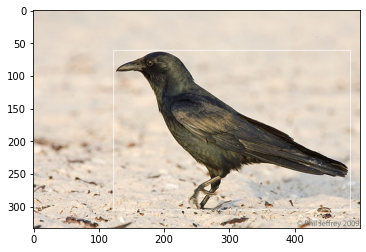

In [16]:
# Get any random label file 
label_file = random.choice(train_annotations_labels)
with open(label_file, "r") as file:
    label_with_bounding_box = file.read().split("\n")[:-1]
    label_with_bounding_box = [x.split(" ") for x in label_with_bounding_box]
    label_with_bounding_box = [[float(y) for y in x ] for x in label_with_bounding_box]

# Get the equal image file
image_file = label_file.replace("annotations", "images").replace("txt", "jpg")

assert os.path.exists(image_file)

# Load the image
image = Image.open(image_file)


# Plot the Bounding Box
plot_image_with_bounding_box(image, label_with_bounding_box)

In [17]:
# Read images and labels
train_images = [os.path.join('/content/Dataset/train_images/', x) for x in os.listdir("/content/Dataset/train_images/") if x[-3:] == 'jpg']
train_labels = [os.path.join('/content/Dataset/train_images/', x) for x in os.listdir('/content/Dataset/train_images/') if x[-3:] == "txt"]

test_images = [os.path.join('/content/Dataset/valid_images/', x) for x in os.listdir("/content/Dataset/valid_images/") if x[-3:] == 'jpg']
test_labels = [os.path.join('/content/Dataset/valid_images/', x) for x in os.listdir('/content/Dataset/valid_images/') if x[-3:] == "txt"]

train_images.sort()
train_labels.sort()

test_images.sort()
test_labels.sort()

# # Split the dataset into valid-test splits 
val_images, test_images, val_label, test_label = train_test_split(test_images, test_labels, test_size = 0.5, random_state = 1)

# check how many image have each categories
len(train_images),len(train_labels),len(val_images),len(val_label),len(test_images),len(test_label)

(5993, 5993, 2897, 2897, 2897, 2897)

In [18]:
!mkdir bird_species  bird_species/train bird_species/train/images bird_species/train/labels 
!mkdir bird_species/val bird_species/val/images bird_species/val/labels
!mkdir bird_species/test bird_species/test/images bird_species/test/labels


In [19]:
#Utility function to move images 
def move_files(list_of_files, dst_folder):
    for f in list_of_files:
        try:
            shutil.move(f, dst_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files(train_images, 'bird_species/train/images/')
print('train')
move_files(val_images, 'bird_species/val/images/')
print('val')
move_files(test_images, 'bird_species/test/images/')
print('test')
move_files(train_labels, 'bird_species/train/labels/')
print('train label')
move_files(val_label, 'bird_species/val/labels/')
print('val_label')
move_files(test_label, 'bird_species/test/labels/')
print('test_label')

train
val
test
train label
val_label
test_label


In [ ]:
 
# Load the model.
model = YOLO('yolov5s.pt')
 
# Training.
model.train(
   data='/content/drive/MyDrive/new_article/Bird-species/bird_spacies.yaml',
   imgsz=640,
   epochs=10, # If you interest to increase epoch than more time to train.
   batch=8, 
   name='yolov8_bird_species'
)

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!yolo task=detect mode=val model=/content/runs/detect/yolov8_bird_species/weights/best.pt name=yolov8s_eval data=/content/drive/MyDrive/new_article/Bird-species/bird_spacies.yaml imgsz=640


Ultralytics YOLOv8.0.49 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 4644824 parameters, 0 gradients, 15.9 GFLOPs
val: Scanning /content/bird_species/val/labels.cache... 2897 images, 0 backgrounds, 0 corrupt: 100% 2897/2897 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 182/182 [00:33<00:00,  5.37it/s]
                   all       2897       2897      0.226      0.334      0.191       0.16
    Acadian Flycatcher       2897         14      0.145      0.357      0.163      0.152
         American Crow       2897         16      0.154      0.938       0.23      0.215
    American Goldfinch       2897         18      0.163      0.556      0.265      0.228
        American Pipit       2897         13     0.0853      0.231      0.113      0.101
     American Redstart       2897         15      0.305      0.467      0.312      0.279
American Three Toed Woodpecker       2897   

In [20]:
from ultralytics import YOLO

file_dir = os.listdir("/content/bird_species/test/images/")

model = YOLO("/content/drive/MyDrive/new_article/Bird-species/best.pt")


In [ ]:
# Load the model.
import os
import random


for i in range(2):
  image = random.choice(file_dir)
  full_path = f"/content/bird_species/test/images/{image}/"
  print(full_path)
  result = model.predict(full_path,save=True)
  print(result)



image 1/1 /content/bird_species/test/images/Field_Sparrow_0038_113356.jpg: 448x640 1 Least Flycatcher, 22.5ms
Speed: 0.7ms preprocess, 22.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict4

image 1/1 /content/bird_species/test/images/Hooded_Merganser_0016_79079.jpg: 480x640 1 Hooded Merganser, 17.4ms
Speed: 0.4ms preprocess, 17.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict4


/content/bird_species/test/images/Field_Sparrow_0038_113356.jpg/
[{ '_keys': <generator object Results.__init__.<locals>.<genexpr> at 0x7f95dd6199e0>,
  'boxes': ultralytics.yolo.engine.results.Boxes
type:  torch.Tensor
shape: torch.Size([1, 6])
dtype: torch.float32
tensor([[1.72000e+02, 7.00000e+01, 3.09000e+02, 3.17000e+02, 2.85981e-01, 1.03000e+02]], device='cuda:0'),
  'masks': None,
  'names': { 0: 'Acadian Flycatcher',
             1: 'American Crow',
             2: 'American Goldfinch',
             3: 'American Pipit',
             4: 'American Redstart',
             5: 'American Three Toed Woodpecker',
             6: 'Anna Hummingbird',
             7: 'Artic Tern',
             8: 'Baird Sparrow',
             9: 'Baltimore Oriole',
             10: 'Bank Swallow',
             11: 'Barn Swallow',
             12: 'Bay Breasted Warbler',
             13: 'Belted Kingfisher',
             14: 'Bewick Wren',
             15: 'Black And White Warbler',
             16: 'Black